In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import wandb

['00', '01', '04', '05', '06', '08', '09', '11', '12', '13', '14', '15', '16', '18', '19', '20', '21', '23', '24', '26', '28', '29', '30', '31', '33', '35', '37', '38', '41', '42', '43', '44', '45', '50', '51', '53', '54', '56', '59', '60', '62', '63', '65', '69', '70', '72', '74', '75', '76', '77', '79', '81', '82', '84', '85', '87', '88', '89', '90', '91', '94', '95', '97', '98']
Dataset CustomImageFolder
    Number of datapoints: 64000
    Root location: double_mnist/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
['03', '07', '10', '22', '27', '34', '39', '40', '48', '52', '58', '61', '64', '71', '93', '99']
tensor([81, 77, 74, 12, 85, 41, 26, 45, 16, 82, 45, 56, 56, 89,  0, 30, 76, 21,
        20, 21, 50, 62, 56, 63, 26, 65, 60, 65, 60, 35, 70, 95, 11, 87,

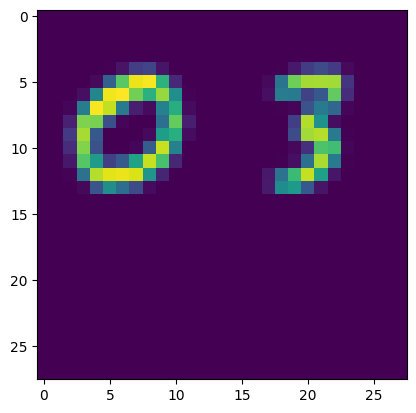

In [2]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data_path = 'double_mnist/train'
val_data_path = 'double_mnist/val'
test_data_path = 'double_mnist/test'
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        folder_name = os.path.basename(os.path.dirname(path))
        return sample, int(folder_name)  
train_dataset = CustomImageFolder(train_data_path, transform=transform)
val_dataset = CustomImageFolder(val_data_path, transform=transform)
test_dataset = CustomImageFolder(test_data_path, transform=transform)
print(train_dataset.classes)
class_to_label = {str(i).zfill(2): i for i in range(100)}
batch_size = 64
print(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = 10

class_names = train_dataset.classes
class_names = val_dataset.classes

print(class_names)

for images, labels in train_loader:
    print(labels)
    break
for images, labels in val_loader:
    plt.imshow(images[0].permute(1, 2, 0))
    print(labels[0])
    print(labels)
    break




In [3]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layers, hidden_neurons, dropout_rate=0.5):
        super(SimpleMLP, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        
        layers = []
        layers.append(nn.Linear(input_size, hidden_neurons[0]))
        layers.append(nn.ReLU())
        for i in range(1, hidden_layers):
            layers.append(nn.Linear(hidden_neurons[i-1], hidden_neurons[i]))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(hidden_neurons[-1], num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = self.hidden(x)
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

input_size = 28 * 28
num_classes = 10
hidden_layers = 3
hidden_neurons = [256,256,256]  
dropout_rate = 0.5


model = SimpleMLP(input_size, num_classes, hidden_layers, hidden_neurons, dropout_rate)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model1 = SimpleMLP(input_size, num_classes, hidden_layers, hidden_neurons, dropout_rate)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)





In [5]:
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    cnt = 0
    for images, labels in train_loader:
        labels1 = labels//10
        labels2 = labels%10
        optimizer1.zero_grad()
        optimizer.zero_grad()
        image = images.clone()
        image1 = images.clone()
        left_half = images[:, :, :, :images.shape[3] // 2]
        image[:, :, :, (image.shape[3] // 2):] = left_half
        right_half = images[:, :, :, images.shape[3] // 2 :]
        image1[:, :, :, :(image1.shape[3] // 2)] = right_half
        outputs = model(image)
        outputs1 = model1(image1)
        loss = criterion(outputs, labels1)
        loss1 = criterion1(outputs1,labels2)
        loss.backward()
        loss1.backward()
        optimizer.step()
        optimizer1.step()
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        _, predicted1 = torch.max(outputs1.data, 1)
        total_train += 2*labels.size(0)
        for i in range(labels.size(0)):
            if(predicted[i] == labels[i]//10):
                correct_train += 1
            if(predicted1[i] == labels[i]%10):
                correct_train += 1
    train_accuracy = 100 * correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {average_train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
    model.eval()
    model1.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    cnt = 0
    with torch.no_grad():
        for images, labels in val_loader:
            labels1 = labels // 10
            labels2 = labels % 10
            image = images.clone()
            image1 = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image[:, :, :, (image.shape[3] // 2):] = left_half
            right_half = images[:, :, :, images.shape[3] // 2 :]
            image1[:, :, :, :(image1.shape[3] // 2)] = right_half
            outputs = model(image)
            outputs1 = model1(image1)
            loss = criterion(outputs, labels1)
            loss1 = criterion1(outputs1,labels2)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, predicted1 = torch.max(outputs1.data, 1)
            total_val += 2*labels.size(0)
            for i in range(labels.size(0)):
                if(predicted[i] == labels[i]//10):
                    correct_val += 1
                if(predicted1[i] == labels[i]%10):
                    correct_val += 1
    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Loss: {average_val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%')
    model.eval()
    model1.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    cnt = 0
    with torch.no_grad():
        for images, labels in test_loader:
            labels1 = labels // 10
            labels2 = labels % 10
            image = images.clone()
            image1 = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image[:, :, :, (image.shape[3] // 2):] = left_half
            right_half = images[:, :, :, images.shape[3] // 2 :]
            image1[:, :, :, :(image1.shape[3] // 2)] = right_half
            outputs = model(image)
            outputs1 = model1(image1)
            loss = criterion(outputs, labels1)
            loss1 = criterion1(outputs1,labels2)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, predicted1 = torch.max(outputs1.data, 1)
            total_val += 2*labels.size(0)
            for i in range(labels.size(0)):
                if(predicted[i] == labels[i]//10):
                    correct_val += 1
                if(predicted1[i] == labels[i]%10):
                    correct_val += 1
    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Testing Loss: {average_val_loss:.4f} - Testing Accuracy: {val_accuracy:.2f}%')


Epoch 1/25 - Train Loss: 1.9690 - Train Accuracy: 29.12%
Epoch 1/25 - Validation Loss: 1.9367 - Validation Accuracy: 32.68%
Epoch 1/25 - Testing Loss: 1.9647 - Testing Accuracy: 22.71%
Epoch 2/25 - Train Loss: 1.7751 - Train Accuracy: 38.38%
Epoch 2/25 - Validation Loss: 1.7664 - Validation Accuracy: 38.00%
Epoch 2/25 - Testing Loss: 1.8324 - Testing Accuracy: 27.10%
Epoch 3/25 - Train Loss: 1.6701 - Train Accuracy: 43.74%
Epoch 3/25 - Validation Loss: 1.6841 - Validation Accuracy: 43.07%
Epoch 3/25 - Testing Loss: 1.7891 - Testing Accuracy: 31.87%
Epoch 4/25 - Train Loss: 1.5503 - Train Accuracy: 47.49%
Epoch 4/25 - Validation Loss: 1.4802 - Validation Accuracy: 48.10%
Epoch 4/25 - Testing Loss: 1.5961 - Testing Accuracy: 37.47%
Epoch 5/25 - Train Loss: 1.4497 - Train Accuracy: 51.95%
Epoch 5/25 - Validation Loss: 1.4572 - Validation Accuracy: 48.67%
Epoch 5/25 - Testing Loss: 1.5138 - Testing Accuracy: 40.95%
Epoch 6/25 - Train Loss: 1.3934 - Train Accuracy: 55.59%
Epoch 6/25 - Valid

In [4]:
# learning_rates = [0.001]
# hidden_layers = [1, 2,3]
# hidden_neurons = [128,256]
wandb.login()
sweep_config = {
    "name": "5.1-MLP Hyperparameter Tuning",
    "method": "grid",
    "parameters": {
        "hidden_layers": {"values": [1,2,3]},
        "hidden_neurons": {"values": [128, 256]},
    },
    "metric": {"goal": "maximize", "name": "test_accuracy"},
}

sweep_id = wandb.sweep(sweep_config, project="5.1-MLP Hyperparameter Tuning")

def train():
    wandb.init(project="5.1-MLP Hyperparameter Tuning")
    j = wandb.config.hidden_layers
    k = wandb.config.hidden_neurons
    kk = [k]*j
    model = SimpleMLP(input_size, num_classes=num_classes, hidden_layers = j, hidden_neurons = kk, dropout_rate = 0.5)
    model1 = SimpleMLP(input_size, num_classes=num_classes, hidden_layers = j, hidden_neurons = kk, dropout_rate = 0.5)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion1 = nn.CrossEntropyLoss()
    optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        cnt = 0
        for images, labels in train_loader:
            labels1 = labels//10
            labels2 = labels%10
            # class_names = train_dataset.classes
            optimizer1.zero_grad()
            optimizer.zero_grad()
            image = images.clone()
            image1 = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            # print(left_half.shape)
            image[:, :, :, (image.shape[3] // 2):] = left_half
            right_half = images[:, :, :, images.shape[3] // 2 :]
            image1[:, :, :, :(image1.shape[3] // 2)] = right_half
            # print(images.shape)
            outputs = model(image)
            outputs1 = model1(image1)
            loss = criterion(outputs, labels1)
            loss1 = criterion1(outputs1,labels2)
            loss.backward()
            loss1.backward()
            optimizer.step()
            optimizer1.step()
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, predicted1 = torch.max(outputs1.data, 1)
            total_train += 2*labels.size(0)
            for i in range(labels.size(0)):
                # cnt += 1
                # if(cnt == 10):
                #     print(predicted[i])
                #     print(predicted1[i])
                #     print(labels[i])
                #     cnt=0
                #     break
                if(predicted[i] == labels[i]//10):
                    correct_train += 1
                if(predicted1[i] == labels[i]%10):
                    correct_train += 1
            # cnt += 1
            # if(cnt == 10):
            #     break
        train_accuracy = 100 * correct_train / total_train
        average_train_loss = total_train_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs} - Hidden layers: {j} - Hidden neurons: {kk} - Train Accuracy: {train_accuracy:.2f}%')
        model.eval()
        model1.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        cnt = 0
        with torch.no_grad():
            for images, labels in test_loader:
                labels1 = labels // 10
                labels2 = labels % 10
                image = images.clone()
                image1 = images.clone()
                left_half = images[:, :, :, :images.shape[3] // 2]
                image[:, :, :, (image.shape[3] // 2):] = left_half
                right_half = images[:, :, :, images.shape[3] // 2 :]
                image1[:, :, :, :(image1.shape[3] // 2)] = right_half
                outputs = model(image)
                outputs1 = model1(image1)
                loss = criterion(outputs, labels1)
                loss1 = criterion1(outputs1,labels2)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                _, predicted1 = torch.max(outputs1.data, 1)
                total_val += 2*labels.size(0)
                for i in range(labels.size(0)):
                    if(predicted[i] == labels[i]//10):
                        correct_val += 1
                    if(predicted1[i] == labels[i]%10):
                        correct_val += 1
        val_accuracy = 100 * correct_val / total_val
        average_val_loss = total_val_loss / len(test_loader)
        print(f'Epoch {epoch + 1}/{num_epochs} - Testing Loss: {average_val_loss:.4f} - Testing Accuracy: {val_accuracy:.2f}%')
    wandb.log({
        "train_accuracy": train_accuracy,
        "test_accuracy": val_accuracy
        })
wandb.agent(sweep_id, function = train)

        


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lsamourya07 (mourya). Use `wandb login --relogin` to force relogin


Create sweep with ID: 5brbpgfk
Sweep URL: https://wandb.ai/mourya/5.1-MLP%20Hyperparameter%20Tuning/sweeps/5brbpgfk


wandb: Agent Starting Run: 70n1e0ee with config:
wandb: 	hidden_layers: 1
wandb: 	hidden_neurons: 128
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/5 - Hidden layers: 1 - Hidden neurons: [128] - Train Accuracy: 22.07%
Epoch 1/5 - Testing Loss: 2.1264 - Testing Accuracy: 14.06%
Epoch 2/5 - Hidden layers: 1 - Hidden neurons: [128] - Train Accuracy: 30.03%
Epoch 2/5 - Testing Loss: 2.0566 - Testing Accuracy: 18.88%
Epoch 3/5 - Hidden layers: 1 - Hidden neurons: [128] - Train Accuracy: 32.26%
Epoch 3/5 - Testing Loss: 2.0639 - Testing Accuracy: 20.36%
Epoch 4/5 - Hidden layers: 1 - Hidden neurons: [128] - Train Accuracy: 33.61%
Epoch 4/5 - Testing Loss: 2.0124 - Testing Accuracy: 23.99%
Epoch 5/5 - Hidden layers: 1 - Hidden neurons: [128] - Train Accuracy: 34.78%
Epoch 5/5 - Testing Loss: 2.0085 - Testing Accuracy: 23.76%


test_accuracy,▁
train_accuracy,▁
test_accuracy,23.76
train_accuracy,34.77578


wandb: Agent Starting Run: 72i7pcpd with config:
wandb: 	hidden_layers: 1
wandb: 	hidden_neurons: 256
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/5 - Hidden layers: 1 - Hidden neurons: [256] - Train Accuracy: 23.95%
Epoch 1/5 - Testing Loss: 2.0938 - Testing Accuracy: 14.97%
Epoch 2/5 - Hidden layers: 1 - Hidden neurons: [256] - Train Accuracy: 32.16%
Epoch 2/5 - Testing Loss: 2.0694 - Testing Accuracy: 20.61%
Epoch 3/5 - Hidden layers: 1 - Hidden neurons: [256] - Train Accuracy: 33.64%
Epoch 3/5 - Testing Loss: 2.0124 - Testing Accuracy: 24.20%
Epoch 4/5 - Hidden layers: 1 - Hidden neurons: [256] - Train Accuracy: 35.17%
Epoch 4/5 - Testing Loss: 2.0062 - Testing Accuracy: 22.78%
Epoch 5/5 - Hidden layers: 1 - Hidden neurons: [256] - Train Accuracy: 36.51%
Epoch 5/5 - Testing Loss: 1.9480 - Testing Accuracy: 26.88%


test_accuracy,▁
train_accuracy,▁
test_accuracy,26.8775
train_accuracy,36.50781


wandb: Agent Starting Run: 5vrvx4az with config:
wandb: 	hidden_layers: 2
wandb: 	hidden_neurons: 128
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/5 - Hidden layers: 2 - Hidden neurons: [128, 128] - Train Accuracy: 29.57%
Epoch 1/5 - Testing Loss: 1.9540 - Testing Accuracy: 22.29%
Epoch 2/5 - Hidden layers: 2 - Hidden neurons: [128, 128] - Train Accuracy: 37.98%
Epoch 2/5 - Testing Loss: 1.8834 - Testing Accuracy: 27.20%
Epoch 3/5 - Hidden layers: 2 - Hidden neurons: [128, 128] - Train Accuracy: 43.37%
Epoch 3/5 - Testing Loss: 1.7159 - Testing Accuracy: 31.83%
Epoch 4/5 - Hidden layers: 2 - Hidden neurons: [128, 128] - Train Accuracy: 47.94%
Epoch 4/5 - Testing Loss: 1.5660 - Testing Accuracy: 37.70%
Epoch 5/5 - Hidden layers: 2 - Hidden neurons: [128, 128] - Train Accuracy: 51.21%
Epoch 5/5 - Testing Loss: 1.4172 - Testing Accuracy: 45.61%


test_accuracy,▁
train_accuracy,▁
test_accuracy,45.6125
train_accuracy,51.20859


wandb: Agent Starting Run: 0xr39ujz with config:
wandb: 	hidden_layers: 2
wandb: 	hidden_neurons: 256
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/5 - Hidden layers: 2 - Hidden neurons: [256, 256] - Train Accuracy: 30.35%
Epoch 1/5 - Testing Loss: 1.9696 - Testing Accuracy: 22.78%
Epoch 2/5 - Hidden layers: 2 - Hidden neurons: [256, 256] - Train Accuracy: 42.38%
Epoch 2/5 - Testing Loss: 1.6943 - Testing Accuracy: 35.81%
Epoch 3/5 - Hidden layers: 2 - Hidden neurons: [256, 256] - Train Accuracy: 52.27%
Epoch 3/5 - Testing Loss: 1.5583 - Testing Accuracy: 48.77%
Epoch 4/5 - Hidden layers: 2 - Hidden neurons: [256, 256] - Train Accuracy: 58.58%
Epoch 4/5 - Testing Loss: 1.5356 - Testing Accuracy: 55.20%
Epoch 5/5 - Hidden layers: 2 - Hidden neurons: [256, 256] - Train Accuracy: 62.48%
Epoch 5/5 - Testing Loss: 1.5594 - Testing Accuracy: 57.45%


test_accuracy,▁
train_accuracy,▁
test_accuracy,57.4475
train_accuracy,62.47578


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mb5fwo4f with config:
wandb: 	hidden_layers: 3
wandb: 	hidden_neurons: 128
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/5 - Hidden layers: 3 - Hidden neurons: [128, 128, 128] - Train Accuracy: 28.58%
Epoch 1/5 - Testing Loss: 2.0627 - Testing Accuracy: 18.29%
Epoch 2/5 - Hidden layers: 3 - Hidden neurons: [128, 128, 128] - Train Accuracy: 38.40%
Epoch 2/5 - Testing Loss: 1.7686 - Testing Accuracy: 27.50%
Epoch 3/5 - Hidden layers: 3 - Hidden neurons: [128, 128, 128] - Train Accuracy: 46.01%
Epoch 3/5 - Testing Loss: 1.5318 - Testing Accuracy: 39.41%
Epoch 4/5 - Hidden layers: 3 - Hidden neurons: [128, 128, 128] - Train Accuracy: 51.82%
Epoch 4/5 - Testing Loss: 1.4508 - Testing Accuracy: 42.84%
Epoch 5/5 - Hidden layers: 3 - Hidden neurons: [128, 128, 128] - Train Accuracy: 56.73%
Epoch 5/5 - Testing Loss: 1.3627 - Testing Accuracy: 49.94%


test_accuracy,▁
train_accuracy,▁
test_accuracy,49.9425
train_accuracy,56.73359


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9htyxcxc with config:
wandb: 	hidden_layers: 3
wandb: 	hidden_neurons: 256
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/5 - Hidden layers: 3 - Hidden neurons: [256, 256, 256] - Train Accuracy: 30.74%
Epoch 1/5 - Testing Loss: 1.9725 - Testing Accuracy: 22.80%
Epoch 2/5 - Hidden layers: 3 - Hidden neurons: [256, 256, 256] - Train Accuracy: 42.86%
Epoch 2/5 - Testing Loss: 1.7036 - Testing Accuracy: 36.24%
Epoch 3/5 - Hidden layers: 3 - Hidden neurons: [256, 256, 256] - Train Accuracy: 54.12%
Epoch 3/5 - Testing Loss: 1.3097 - Testing Accuracy: 52.64%
Epoch 4/5 - Hidden layers: 3 - Hidden neurons: [256, 256, 256] - Train Accuracy: 62.67%
Epoch 4/5 - Testing Loss: 1.2856 - Testing Accuracy: 57.21%
Epoch 5/5 - Hidden layers: 3 - Hidden neurons: [256, 256, 256] - Train Accuracy: 68.72%
Epoch 5/5 - Testing Loss: 1.1196 - Testing Accuracy: 66.38%


test_accuracy,▁
train_accuracy,▁
test_accuracy,66.375
train_accuracy,68.71563


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# 5.1.3 (Testing on regular MNIST)

In [13]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
total_size = len(trainset)
train_size = int(0.8 * total_size)
validation_size = int(0.1 * total_size)
test_size = total_size - train_size - validation_size

# Split the dataset
gen = torch.Generator().manual_seed(42)
train_set, validation_set, test_set = random_split(trainset, [train_size, validation_size, test_size],generator=gen)

# Create data loaders for each set
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True,generator=gen)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

input_size = 28 * 28
num_classes = 10
hidden_layers = 3
hidden_neurons = [256,256,256]
dropout_rate = 0.5


model = SimpleMLP(input_size, num_classes, hidden_layers, hidden_neurons, dropout_rate)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model1 = SimpleMLP(input_size, num_classes, hidden_layers, hidden_neurons, dropout_rate)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    cnt = 0
    for images, labels in train_loader:
        labels1 = labels//10
        labels2 = labels%10
        optimizer1.zero_grad()
        optimizer.zero_grad()
        image = images.clone()
        image1 = images.clone()
        left_half = images[:, :, :, :images.shape[3] // 2]
        image[:, :, :, (image.shape[3] // 2):] = left_half
        right_half = images[:, :, :, images.shape[3] // 2 :]
        image1[:, :, :, :(image1.shape[3] // 2)] = right_half
        outputs = model(image)
        outputs1 = model1(image1)
        loss = criterion(outputs, labels1)
        loss1 = criterion1(outputs1,labels2)
        loss.backward()
        loss1.backward()
        optimizer.step()
        optimizer1.step()
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        _, predicted1 = torch.max(outputs1.data, 1)
        total_train += 2*labels.size(0)
        for i in range(labels.size(0)):
            if(predicted[i] == labels[i]//10):
                correct_train += 1
            if(predicted1[i] == labels[i]%10):
                correct_train += 1
    train_accuracy = 100 * correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {average_train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
    model.eval()
    model1.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    cnt = 0
    with torch.no_grad():
        for images, labels in testloader:
            labels1 = labels // 10
            labels2 = labels % 10
            image = images.clone()
            image1 = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image[:, :, :, (image.shape[3] // 2):] = left_half
            right_half = images[:, :, :, images.shape[3] // 2 :]
            image1[:, :, :, :(image1.shape[3] // 2)] = right_half
            outputs = model(image)
            outputs1 = model1(image1)
            loss = criterion(outputs, labels1)
            loss1 = criterion1(outputs1,labels2)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, predicted1 = torch.max(outputs1.data, 1)
            total_val += 2*labels.size(0)
            for i in range(labels.size(0)):
                if(predicted[i] == labels[i]//10):
                    correct_val += 1
                if(predicted1[i] == labels[i]%10):
                    correct_val += 1
    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Testing Loss: {average_val_loss:.4f} - Testing Accuracy: {val_accuracy:.2f}%')





Epoch 1/10 - Train Loss: 1.9254 - Train Accuracy: 29.83%
Epoch 1/10 - Testing Loss: 1.8771 - Testing Accuracy: 12.67%
Epoch 2/10 - Train Loss: 1.5908 - Train Accuracy: 43.52%
Epoch 2/10 - Testing Loss: 3.8163 - Testing Accuracy: 7.15%
Epoch 3/10 - Train Loss: 1.3089 - Train Accuracy: 56.22%
Epoch 3/10 - Testing Loss: 4.8375 - Testing Accuracy: 6.52%
Epoch 4/10 - Train Loss: 1.1054 - Train Accuracy: 65.05%
Epoch 4/10 - Testing Loss: 4.9387 - Testing Accuracy: 6.93%
Epoch 5/10 - Train Loss: 0.9295 - Train Accuracy: 71.27%
Epoch 5/10 - Testing Loss: 4.9218 - Testing Accuracy: 7.92%
Epoch 6/10 - Train Loss: 0.8090 - Train Accuracy: 74.94%
Epoch 6/10 - Testing Loss: 5.6319 - Testing Accuracy: 6.92%
Epoch 7/10 - Train Loss: 0.7375 - Train Accuracy: 77.50%
Epoch 7/10 - Testing Loss: 6.1998 - Testing Accuracy: 7.36%
Epoch 8/10 - Train Loss: 0.6779 - Train Accuracy: 79.31%
Epoch 8/10 - Testing Loss: 6.8312 - Testing Accuracy: 7.67%
Epoch 9/10 - Train Loss: 0.6392 - Train Accuracy: 80.62%
Epoch 